# K-Means Clustering

In this notebook I look to use K-Means clustering to group customers with other like customers, which will help companies run targeted advertising campaigns.

In [1]:
%matplotlib notebook

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

In [3]:
#Load dataset and make it into pandas dataframe

path = 'data-raw/customer-segmentation-dataset/Mall_Customers.csv'
def load_file(path):
    try:
        df = pd.read_csv(path)
    except:
        return 'Error Retrieving File'
    return df

df = load_file(path)

In [4]:
##Clean data
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
##See which columns have NA values and how many

def check_NA(df):
    nalist = []
    for i in df.columns:
        nalist.append(df[i].isnull().sum())
    return nalist
NAs = check_NA(df)
NAs

[0, 0, 0, 0, 0]

In [6]:
##Summarize each variable if possible.

def print_summaries(df):
    for i in df.columns:
        try:
            print('Column', i)
            print('Mean', np.mean(df[i]))
            print('Median', np.median(df[i]))
            print('SD', np.std(df[i]))
            print('Min', min(df[i]))
            print('Max', max(df[i]))
        except:
            pass

##Summize a single variable
def summarize_column(df, i):
    return [('Mean', np.mean(df[i])), ('Median', np.median(df[i])),('SD', np.std(df[i])),('Min', min(df[i])),('Max', max(df[i]))]
        
print_summaries(df)

Column CustomerID
Mean 100.5
Median 100.5
SD 57.73430522661548
Min 1
Max 200
Column Gender
Column Age
Mean 38.85
Median 36.0
SD 13.934041050606966
Min 18
Max 70
Column Annual Income (k$)
Mean 60.56
Median 61.5
SD 26.19897707926782
Min 15
Max 137
Column Spending Score (1-100)
Mean 50.2
Median 50.0
SD 25.75888196331509
Min 1
Max 99


The dataset is very clean. There are no null values, the customerID is between 1-200, the Age is between 18-70, income between 15-137k, and score between 1-99. Let us visualize the different variables.

<IPython.core.display.Javascript object>


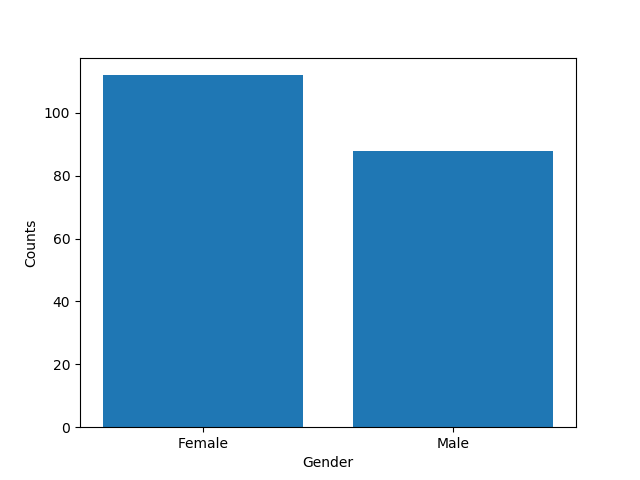

In [7]:
#Creates a simple barplot by the user given variable

def barplot_of_counts(df, column, myxlabel, myylabel):
    groups = df.groupby(column).groups
    index = range(len(list(dict(groups))))
    plt.figure()
    plt.bar(list(index) , df.groupby(column).size())
    plt.xlabel(myxlabel)
    plt.ylabel(myylabel)
    plt.xticks((list(index)), (list(dict(groups))))
    
#Plot GENDER
barplot_of_counts(df, 'Gender', 'Gender', 'Counts')

In [8]:
##Calculate proportion of women in dataset
len(df[df['Gender'] == 'Female'])/len(df)

0.56

[('Mean', 38.85), ('Median', 36.0), ('SD', 13.934041050606966), ('Min', 18), ('Max', 70)]


<IPython.core.display.Javascript object>


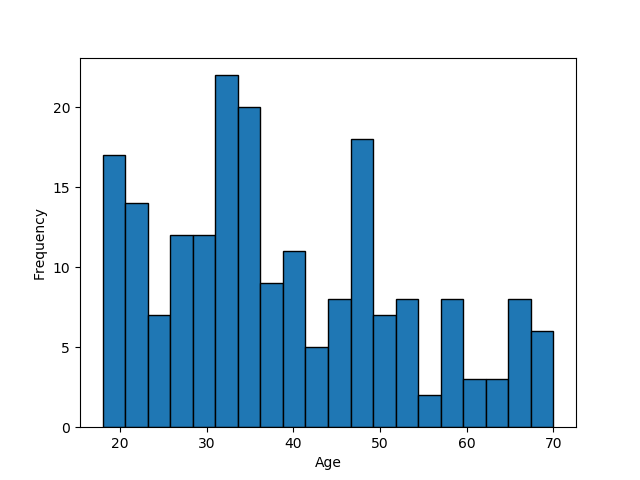

In [9]:
##Creates a simple histogram by user given variable

def histogram(df, column, myxlabel, myylabel, bins):
    plt.figure()
    plt.hist(df[column], bins = bins, ec = 'black')
    plt.xlabel(myxlabel)
    plt.ylabel(myylabel)

#Summarize and plot AGE
age_summary = summarize_column(df, 'Age')
print(age_summary)
histogram(df, 'Age', 'Age', 'Frequency', 20)

<IPython.core.display.Javascript object>


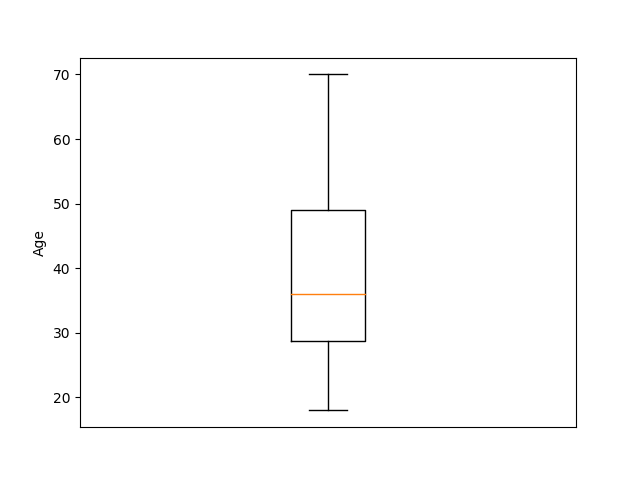

In [10]:
##Creates a simple boxplot by user given variable

def boxplot(df, column, myylabel):
    plt.figure()
    plt.boxplot(df[column])
    plt.xticks((),())
    plt.ylabel(myylabel)

boxplot(df, 'Age', 'Age')

[('Mean', 60.56), ('Median', 61.5), ('SD', 26.19897707926782), ('Min', 15), ('Max', 137)]


<IPython.core.display.Javascript object>


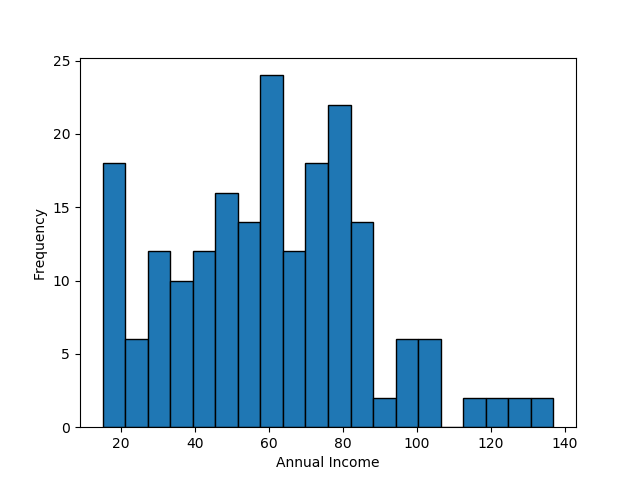

In [11]:
##Summarize and plot INCOME
income_summary = summarize_column(df, 'Annual Income (k$)')
print(income_summary)

histogram(df, 'Annual Income (k$)', 'Annual Income', 'Frequency', 20)

<IPython.core.display.Javascript object>


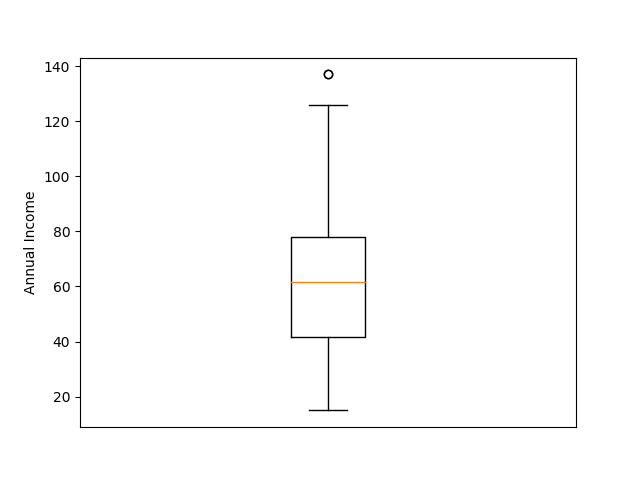

In [12]:
boxplot(df, 'Annual Income (k$)', 'Annual Income')

[('Mean', 50.2), ('Median', 50.0), ('SD', 25.75888196331509), ('Min', 1), ('Max', 99)]


<IPython.core.display.Javascript object>


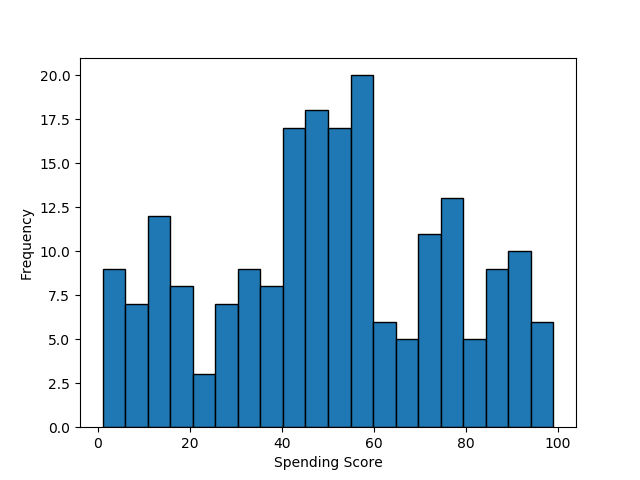

In [13]:
#Summarize and plot Spending Score
spend_summary = summarize_column(df, 'Spending Score (1-100)')
print(spend_summary)

histogram(df, 'Spending Score (1-100)', 'Spending Score', 'Frequency', 20)

<IPython.core.display.Javascript object>


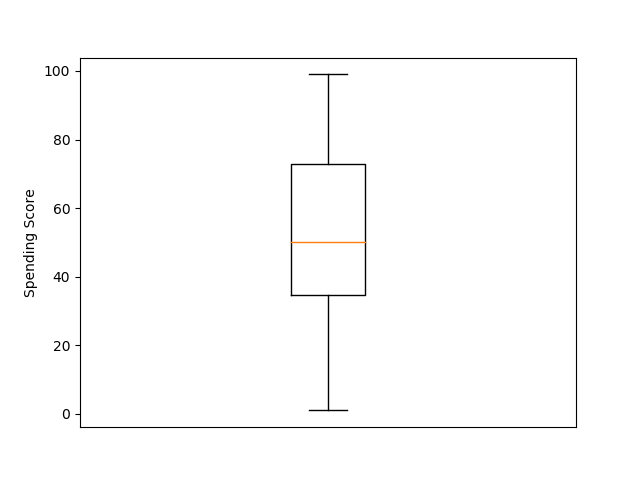

In [14]:
boxplot(df, 'Spending Score (1-100)', 'Spending Score')

We could also make scatterplots of the variables against each other, but we will clearly be able to see these relationships once we start our KMeans process.

## Kmeans

Now that we have a feel for all the variables in the dataset and there appear to be no issues with the data or distributions, we can move on to the clustering algorithm. We will use KMeans to attempt to cluster the customers into distinct groups. For this application I will not be using Gender as categorical variables are not appropriate for a KMeans algorithm. A followup application could be to find a different algorithm to include Gender as a variable

In [15]:
#Set seed and select features
np.random.seed(0)
features = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

#Function to scale features as KMeans evaluates based on distance
def standardize_features(features):
    scaler = StandardScaler()
    new_features = scaler.fit_transform(X = features)
    return new_features

#Make scaled feature DF
features = standardize_features(features)
features = pd.DataFrame(features)
features.columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

In [16]:
#Function to make KMeans
def KMeans_predict(X, n_clusters = 4):
    kmeans = KMeans(n_clusters).fit(X)
    y = kmeans.predict(X)
    return y

#Function to calculate distance between cluster center and predicted
def calculate_distances(cluster, X):
    distances = [np.mean(pairwise_distances(X[cluster == c])) for c in np.unique(cluster)]
    return np.mean(distances)

#Calculate mean intra-cluster distance for different values of starting clusters K
distances = []
ks = range(2, 11)
for i in range(2, 11):
    y = KMeans_predict(features, i)
    distances.append(calculate_distances(y, features))


<IPython.core.display.Javascript object>


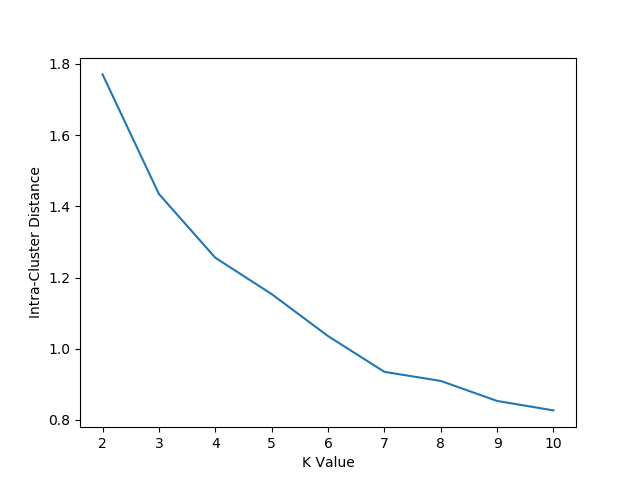

In [17]:
#Function to make simple line plots
def line_plot(x, y, xlabel, ylabel):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
line_plot(ks, distances, 'K Value', 'Intra-Cluster Distance')

The 'Elbow' in the graph, if there is one, is at either k = 4 or k = 7.

However this test is not at all definitive, so I would like to look at other metrics to evaluate the proper number of clusters. I will examine both the silhouette score and gap score of the KMeans algorithm.

In [18]:
#Calculate silhouette score
def silhouette(X, y):
    silhouette = silhouette_score(X, y, metric = 'euclidean')
    return silhouette

In [19]:
#Find silhouette score for varying values of k
sil_scores = []
for i in ks:
    y = KMeans_predict(features, i)
    sil_scores.append(silhouette(features, y))


<IPython.core.display.Javascript object>


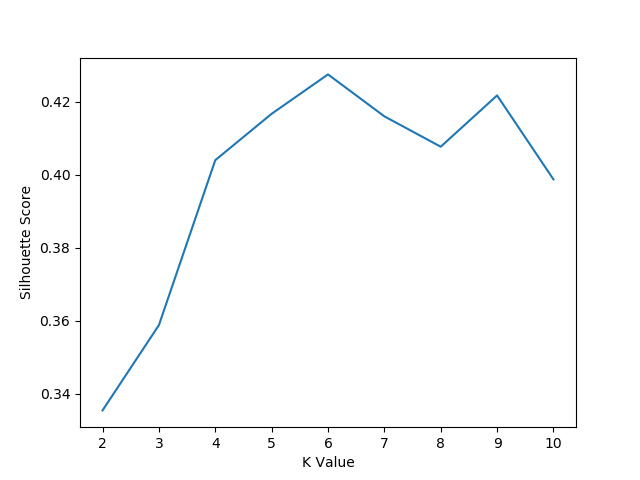

In [20]:
#Graph silhouette score vs K
line_plot(ks, sil_scores, 'K Value', 'Silhouette Score')

The silhouette score seems to indicate that 6 is a better choice of K, rather than 4. We will use the gap score to break the tie.

In [33]:
#Compute the gap score
def compute_gap(X, k = 4, n_reps = 10):
    #Creat random data in same shape as feature space
    mc = np.random.rand(*X.shape)
    mc_distances = []
    for i in range(n_reps):
        y = KMeans_predict(mc, k)
        mc_distances.append(calculate_distances(y, mc))
    mc_distance = np.mean(mc_distances)
    
    y2 = KMeans_predict(X, k)
    X_distance = calculate_distances(y2, X)
    
    gap = np.log(mc_distance) - np.log(X_distance)
    return gap
    
#Calculate gap score across all k values. I use 500 MC simulations to generate stable estimates of the gap score.
gaps = []
for i in ks:
    gaps.append(compute_gap(features, i, 1000))

<IPython.core.display.Javascript object>


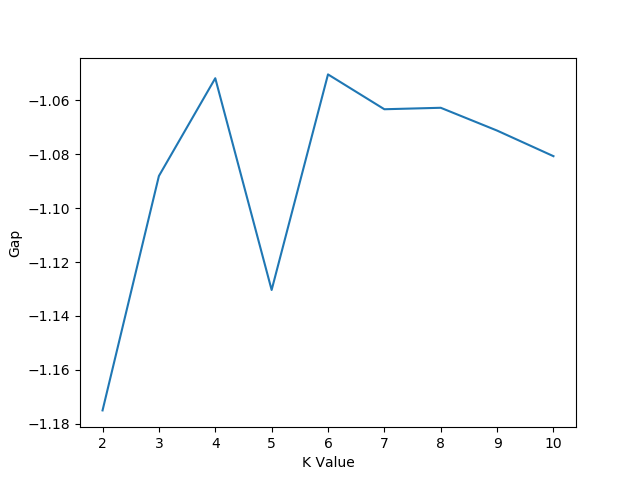

In [34]:
line_plot(ks, gaps, 'K Value', 'Gap')

The Gap score seems to indicate clusters of either 4 or 6 again. I will select 6 as this was clearly indicated by the silhouette score as well as the gap score.

In [35]:
df['Cluster'] = KMeans_predict(features, 6)

<IPython.core.display.Javascript object>


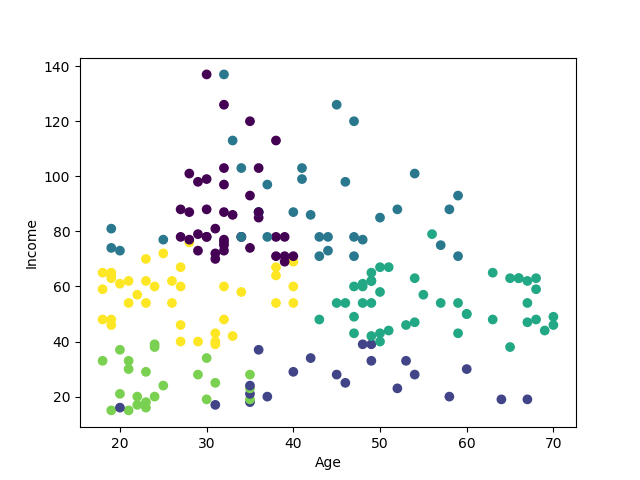

<IPython.core.display.Javascript object>


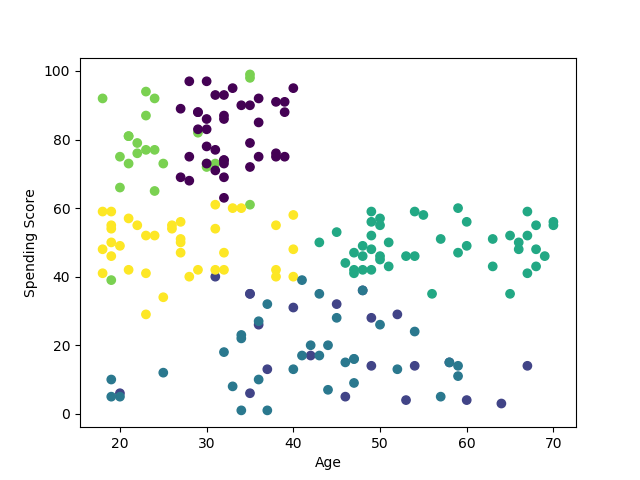

<IPython.core.display.Javascript object>


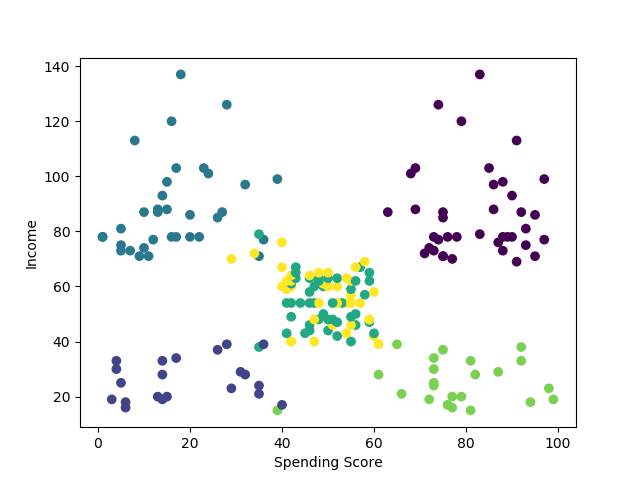

In [36]:
def make_scatter(df, x, y, c, xlabel = None, ylabel = None):
    plt.figure()
    plt.scatter(df[x], df[y], c = df[c])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
make_scatter(df, 'Age', 'Annual Income (k$)', 'Cluster', 'Age', 'Income')
make_scatter(df, 'Age', 'Spending Score (1-100)', 'Cluster', 'Age', 'Spending Score')
make_scatter(df, 'Spending Score (1-100)', 'Annual Income (k$)', 'Cluster', 'Spending Score', 'Income')

We see that the clusters are splitting well. We seem to have clusters with the following attributes.

4 clusters are clearly definited by the bottom scatterplot. These are:

1 - Low Income Low Spending Score

2 - Low Income High Spending Score

3 - High Income Low Spending Score

4 - High Income High Spending Score

It appears that there is some correlation between Age and Spending score, as amongst these groups, the High Spending Score groups seem to have low ages as well.

The other two clusters are very clearly split by the age variable as we can see from the other two scatterplots. Thus we have:

5 - Medium Income/Spending Score, Low Age

6 - Medium Income/Spending Score, High Age



We can also visualize the clusters by breaking down their principle components.

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) #We only keep 2 components as we are planning to visualize

pcomps = pca.fit_transform(features)
pdf = pd.DataFrame(pcomps, columns = ['PC1', 'PC2'])
pdf['Cluster'] = KMeans_predict(features, 6)

<IPython.core.display.Javascript object>


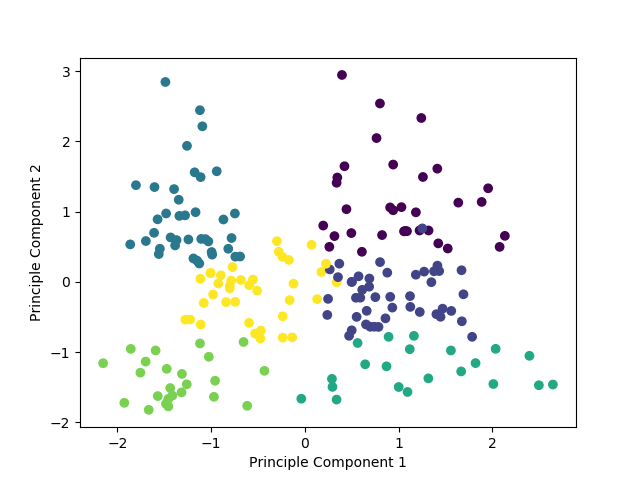

In [38]:
make_scatter(pdf, 'PC1', 'PC2', 'Cluster', 'Principle Component 1', 'Principle Component 2')

We see from these principle components that the 6 clusters are being clearly split out from one another. There is some overlap but on the whole they form 6 distinct groups. This likely could become even clearer by including more principle components, but that seems unnecessary on a low-dimensional dataset such as this one.

Next steps would be to obtain purchase data on customers within each cluster in order to help effectively market to these groups. Obtaining data on what each group of customers is purchasing would allow us to market those items to the groups individually, potentially increasing sales while also increasing customer satisfaction and retention.